In [127]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [128]:
#Obtenha a cotação 
df = web.DataReader ('PETR3.SA', data_source = 'yahoo',  start = '2012-01-01', end = '2020-10-30')
 #Mostre os dados 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,23.610001,22.740000,23.129999,23.209999,3758200.0,20.532776
2012-01-03,24.020000,23.209999,23.209999,24.020000,5402100.0,21.249342
2012-01-04,24.280001,23.570000,23.799999,24.170000,4588400.0,21.382040
2012-01-05,24.309999,23.760000,24.100000,24.020000,7905400.0,21.249342
2012-01-06,24.350000,23.910000,24.100000,24.000000,3454500.0,21.231651
...,...,...,...,...,...,...
2020-10-26,20.500000,19.930000,20.290001,20.200001,11999300.0,20.200001
2020-10-27,20.320000,19.780001,20.200001,19.860001,15695700.0,19.860001
2020-10-28,19.440001,18.639999,19.379999,18.639999,31146900.0,18.639999


In [129]:
df.shape

(2189, 6)

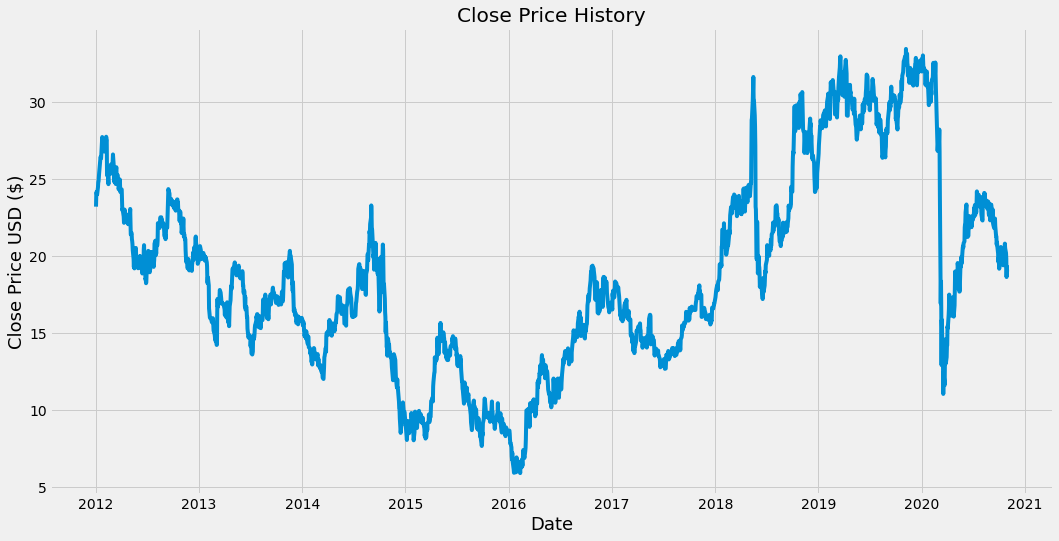

In [130]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [131]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [132]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [133]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [134]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [135]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [136]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=25))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [137]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
1692/1692 [==============================] - 42s 25ms/step - loss: 0.0029
Epoch 2/2
1692/1692 [==============================] - 47s 27ms/step - loss: 0.0011


In [140]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [141]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [142]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [143]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [144]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.9152745147629232

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


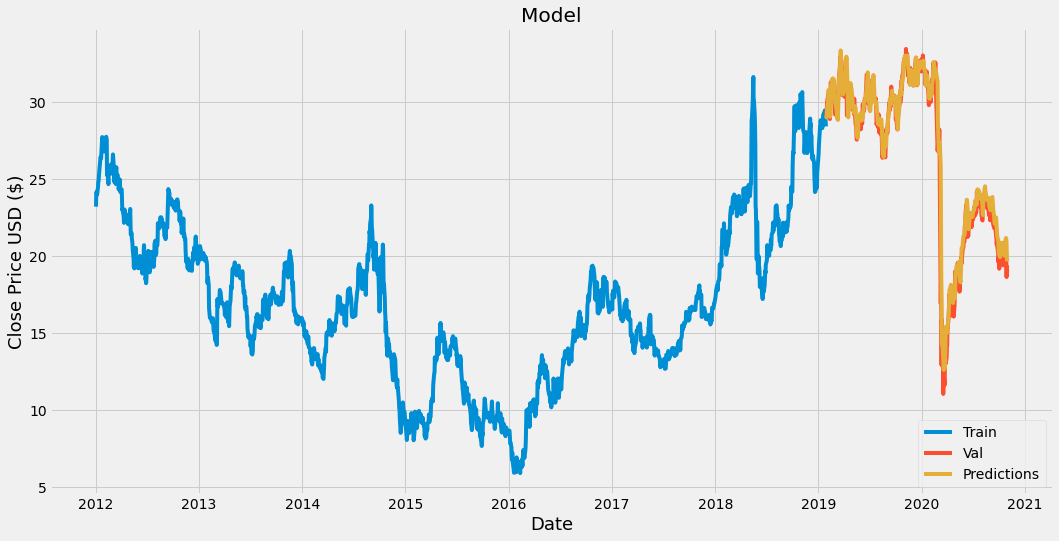

In [145]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [152]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-01-29,29.040001,29.070625
2019-01-30,29.440001,29.001328
2019-01-31,29.549999,29.245840
2019-02-01,30.020000,29.537157
2019-02-04,30.360001,29.969830
...,...,...
2020-10-26,20.200001,21.174984
2020-10-27,19.860001,21.100897
2020-10-28,18.639999,20.802427


In [147]:
#Get the quote
apple_quote = web.DataReader('PETR3.SA', data_source = 'yahoo', start = '2012-01-01', end = '2020-10-30')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[19.413322]]


In [150]:
#Get the quote
apple_quote2 = web.DataReader('PETR3.SA', data_source = 'yahoo', start = '2012-01-01', end = '2020-11-01')
print(apple_quote2['Close'])

Date
2012-01-02    23.209999
2012-01-03    24.020000
2012-01-04    24.170000
2012-01-05    24.020000
2012-01-06    24.000000
                ...    
2020-10-26    20.200001
2020-10-27    19.860001
2020-10-28    18.639999
2020-10-29    19.330000
2020-10-30    19.000000
Name: Close, Length: 2189, dtype: float64
